# Demo individual GP PDF

In [1]:
import sys
import numpy as np
import itertools
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
from matplotlib.colors import LogNorm
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [4]:
FLAG_DC2=True
if FLAG_DC2:
    configfilename='tmp/parametersTest.cfg'
    flux_multiplicative_factor=1.
    flux_multiplicative_factor2=1.
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level
else:
    configfilename='tmpsim/parametersTest.cfg'
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level

In [5]:
# Parse parameters file
#if len(sys.argv) < 2:
#    raise Exception('Please provide a parameter file')
params = parseParamFile(configfilename, verbose=False)

# Read filter coefficients, compute normalization of filters
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
numBands = bandCoefAmplitudes.shape[0]

redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
f_mod = readSEDs(params)

numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
print('Number of Training Objects', numObjectsTraining)

gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              params['lines_pos'], params['lines_width'],
              params['V_C'], params['V_L'],
              params['alpha_C'], params['alpha_L'],
              redshiftGridGP, use_interpolators=True)

numZ = redshiftGrid.size
all_z = np.zeros((numObjectsTraining, ))
all_fluxes = np.zeros((numObjectsTraining, numBands))
all_fluxes_var = np.zeros((numObjectsTraining, numBands))
bestTypes = np.zeros((numObjectsTraining, ), dtype=int)
model_mean = np.zeros((numZ, numObjectsTraining, numBands))
model_covar = np.zeros((numZ, numObjectsTraining, numBands))
bandIndices_TRN, bandNames_TRN, bandColumns_TRN,\
    bandVarColumns_TRN, redshiftColumn_TRN,\
    refBandColumn_TRN = readColumnPositions(params, prefix='training_')
bandIndices, bandNames, bandColumns,\
    bandVarColumns, redshiftColumn,\
    refBandColumn = readColumnPositions(params, prefix='target_')
bandNames = params['bandNames']
Ncompress = params['Ncompress']


dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
f_mod = np.zeros((redshiftGrid.size, len(sed_names),
                  len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name +
                                '_fluxredshiftmod.txt')

<ipython-input-5-70f489debd3e>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))


Number of Training Objects 3755


In [6]:
print(bandIndices, bandNames)

[0 1 2 3 4 5] ['lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y']


AttributeError: 'PhotozGP' object has no attribute 'drawSED'

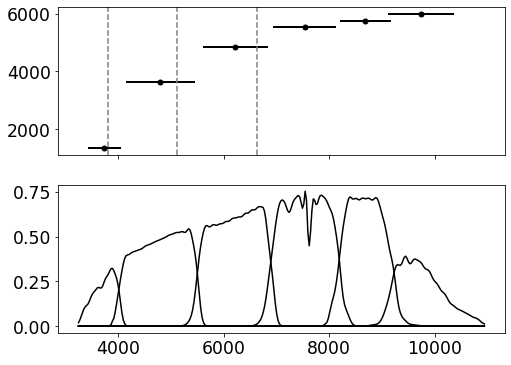

In [7]:
loc = - 1
trainingDataIter = getDataFromFile(params, 0, numObjectsTraining,
                                   prefix="training_", getXY=True)
targetDataIter = getDataFromFile(params, 0, numObjectsTraining,
                                 prefix="target_", getXY=False)
for z, normedRefFlux, bands, fluxes, fluxesVar, bCV, fCV, fvCV, X, Y, Yvar\
        in trainingDataIter:
    loc += 1

    themod = np.zeros((1, f_mod.shape[1], bands.size))
    for it in range(f_mod.shape[1]):
        for ib, band in enumerate(bands):
            themod[0, it, ib] = np.interp(z, redshiftGrid, f_mod[:, it, band])
    chi2_grid , ellMLs= scalefree_flux_likelihood(
        fluxes,
        fluxesVar,
        themod,
        returnChi2=True
    )
    bestTypes[loc] = np.argmin(chi2_grid)
    
    
    gp.setData(X, Y, Yvar, bestTypes[loc])

    ell = gp.X[0, 2]
    model_mean[:, loc, :], model_covar[:, loc, :]\
        = gp.predictAndInterpolate(redshiftGrid, ell=ell, z=z)
    all_z[loc] = z
    all_fluxes[loc, bands] = fluxes
    all_fluxes_var[loc, bands] = fluxesVar

    if True:
        wavs = np.linspace(bandCoefPositions.min(),
                           bandCoefPositions.max(), num=300)
        fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
        for mu in params['lines_pos']:
            axs[0].axvline(mu*(1+z), c='gray', ls='dashed')
        filterMidWav = 0*bandIndices_TRN
        filterStdWav = 0*bandIndices_TRN
        for i, ib in enumerate(bandIndices_TRN):
            y = 0*wavs
            for amp,     mu, sig in zip(bandCoefAmplitudes[ib, :],
                                    bandCoefPositions[ib, :],
                                    bandCoefWidths[ib, :]):
                y += amp * np.exp(-0.5*((wavs-mu)/sig)**2)
            filterMidWav[i] = np.average(wavs, weights=y)
            filterStdWav[i] = np.sqrt(
                np.average((wavs-filterMidWav[i])**2, weights=y))
            axs[1].plot(wavs, y, c='k')
            axs[0].errorbar(filterMidWav[i], Y[i, 0],
                            yerr=np.sqrt(Yvar[i, 0]), xerr=1.5*filterStdWav[i],
                            fmt='-o', markersize=5, color='k', lw=2)
        sed, fac, cov, filters = gp.drawSED(z, ell, wavs)
        sed = np.interp(wavs, filterMidWav[:], Y[:, 0])
        sedfluxes = np.zeros((bandIndices_TRN.size, ))
        for i, ib in enumerate(bandIndices_TRN):
            sedfluxes[i] = np.trapz(filters[ib]*sed, x=wavs) /\
                np.trapz(filters[ib], x=wavs)
        lp = np.sum(-0.5*(sedfluxes - fluxes)**2/fluxesVar)
        numsamples = 200
        seds = np.zeros((numsamples, wavs.size))
        off = 0
        for i in range(numsamples):
            sed_p = 1*sed +\
                fac * np.random.multivariate_normal(0*wavs, cov/10**2)
            for i, ib in enumerate(bandIndices_TRN):
                sedfluxes[i] = np.trapz(filters[ib]*sed_p, x=wavs) /\
                    np.trapz(filters[ib], x=wavs)
            lp_prime = np.sum(-0.5*(sedfluxes - fluxes)**2/fluxesVar)
            if np.random.rand() <= np.exp(lp_prime - lp):
                sed = 1*sed_p
                seds[off, :] = sed_p
                off += 1
                lp = 1*lp_prime
        print("Number of accepted samples:", off)
        sedmean, sedstd = seds[:off, :].mean(axis=0), seds[:off, :].std(axis=0)
        axs[0].plot(wavs, sedmean, c='b')
        axs[0].fill_between(wavs, sedmean+sedstd, sedmean-sedstd,
                            color='b', alpha=0.2)
        for i in np.random.choice(off, 2, replace=False):
            axs[0].plot(wavs, seds[i, :], c='k', alpha=0.3)
        axs[0].set_ylabel('Flux')
        axs[1].set_ylabel('Filters')
        axs[1].set_xlabel('Wavelength')
        # axs[0].set_yscale('log')
        axs[1].set_xlim([wavs[0], wavs[-1]])
        axs[1].set_ylim([0, 1.1*np.max(filters)])
        axs[1].set_yticks([])
        fig.tight_layout()
        fig.savefig('data/data-sed-'+str(loc)+'.png')



In [ ]:
p_t = params['p_t'][bestTypes][None, :]
p_z_t = params['p_z_t'][bestTypes][None, :]

prior = np.exp(-0.5*((redshiftGrid[:, None]-all_z[None, :]) /
                     params['zPriorSigma'])**2)
# prior[prior < 1e-6] = 0
# prior *= p_t * redshiftGrid[:, None] *
# np.exp(-0.5 * redshiftGrid[:, None]**2 / p_z_t) / p_z_t

loc = -1
for z, normedRefFlux, bands, fluxes, fluxesVar,\
        bCV, fCV, fvCV in targetDataIter:
    loc += 1
    fulllike_grid = approx_flux_likelihood(
        fluxes,
        fluxesVar,
        model_mean[:, :, bands],
        f_mod_covar=model_covar[:, :, bands],
        marginalizeEll=True,
        ell_hat=1, ell_var=params['ellPriorSigma']**2
    )
    fulllike_grid *= prior
    evidences = np.trapz(fulllike_grid, x=redshiftGrid, axis=0)
    sortind = np.argsort(evidences)[::-1][0:Ncompress]
    like_grid = fulllike_grid.sum(axis=1)
    like_grid_comp = fulllike_grid[:, sortind].sum(axis=1)
    alllike_grid_cww = approx_flux_likelihood(
        fluxes,
        fluxesVar,
        f_mod[:, :, bands],
        marginalizeEll=True
    )
    besttype = np.argmax(alllike_grid_cww.sum(axis=0))
    like_grid_cww = alllike_grid_cww.sum(axis=1)  # [:, besttype]
    if like_grid.sum() > 0:
        zphotmean = np.average(redshiftGrid, weights=like_grid)
        if zphotmean > 0.0 and zphotmean < 2.5 and z < 2.8:

            fig, ax = plt.subplots(1, 1, figsize=(7, 4))
            for ii in sortind:
                ax.plot(redshiftGrid, fulllike_grid[:, ii], c='gray', alpha=.6)
            ax.plot(redshiftGrid, like_grid, c='k', lw=2, label='GP')
            like_grid_cww = like_grid_cww * np.max(like_grid) /\
                np.max(like_grid_cww)
            ax.plot(redshiftGrid, like_grid_cww,
                    c='blue', lw=2, label='CWW')
            ax.plot(redshiftGrid, like_grid_comp,
                    c='r', ls='dashed', label='Compressed GP')
            ax.axvline(z, c='orange', lw=2, ls='dashed', label='True redshift')

            # ax.axvline(zphotmean, c='r', lw=2)
            ax.set_ylabel('Likelihood')
            ax.set_xlabel('Redshift')
            ax.set_xlim([0, 2.])  # redshiftGrid[-1]])
            ylimax = 1.3*np.max(np.concatenate((like_grid, like_grid_cww)))
            ax.set_ylim([0, ylimax])
            for ii in sortind:
                ax.scatter(all_z[ii], ylimax*0.99, c='gray', marker='x', s=10)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
            ax.legend(loc='upper right', frameon=False, ncol=2)
            # ax.set_yscale('log')
            fig.tight_layout()
            fig.savefig('data/data-pdfs-'+str(loc)+'.pdf')

            if True:
                usedBands = list(np.unique(np.concatenate((
                    bandIndices_TRN, bandIndices))))

                fig, axs = plt.subplots(3, len(usedBands)//3 + 1,
                                        figsize=(10, 5),
                                        sharex=True, sharey=True)
                axs = axs.ravel()
                fac = redshiftGrid**2
                ylims = [0.25*np.min(model_mean[2:-2, :, :] *
                                     fac[2:-2, None, None]),
                         2*np.max(model_mean[2:-2, :, :] *
                                  fac[2:-2, None, None])]
                for i, ib in enumerate(bands):
                    pos = usedBands.index(ib)
                    axs[pos].axvline(zphotmean, c='r', lw=2)
                    axs[pos].axvline(z, c='k', lw=2)
                    axs[pos].axhspan(fluxes[i] - np.sqrt(fluxesVar[i]),
                                     fluxes[i] + np.sqrt(fluxesVar[i]),
                                     color='k', alpha=0.4)
                for i, ib in enumerate(usedBands):
                    for t, sed_name in enumerate(sed_names):
                        if t == besttype:
                            fac = ell
                            fac /= np.interp(z, redshiftGrid, f_mod[:, t, ib])
                            axs[i].plot(redshiftGrid, f_mod[:, t, ib]*fac, 'k')
                for ii in sortind:
                    for i, ib in enumerate(bandIndices_TRN):
                        if False and all_fluxes[ii, ib] > 0:
                            pos = usedBands.index(ib)
                            axs[pos].errorbar(all_z[ii], all_fluxes[ii, ib],
                                              np.sqrt(all_fluxes_var[ii, ib]),
                                              fmt='-o', markersize=5, alpha=.1)
                    for i, ib in enumerate(usedBands):
                        axs[i].set_title(bandNames[ib])
                        axs[i].axvline(all_z[ii], c='gray', alpha=0.3)
                        fac = ell /\
                            np.interp(z, redshiftGrid, model_mean[:, ii, ib])
                        axs[i].fill_between(
                            redshiftGrid,
                            (model_mean[:, ii, ib] -
                             np.sqrt(model_covar[:, ii, ib]))*fac,
                            (model_mean[:, ii, ib] +
                             np.sqrt(model_covar[:, ii, ib]))*fac,
                            color='b', alpha=0.1)
                        # axs[i].plot(redshiftGrid, model_mean[:, ii, ib],
                        # c='b', alpha=0.1)
                        axs[i].set_yscale('log')
                        # axs[i].set_ylim(ylims)
                        axs[i].set_xlim([redshiftGrid[0], redshiftGrid[-1]])

                fig.tight_layout()
                fig.savefig('data/data-fluxes-'+str(loc)+'.pdf')

    if loc > 2050:
        exit(1)


<ipython-input-8-f826e2d2b285>:101: RuntimeWarning: divide by zero encountered in double_scalars
  fac = ell /\
<ipython-input-8-f826e2d2b285>:105: RuntimeWarning: invalid value encountered in multiply
  (model_mean[:, ii, ib] -
<ipython-input-8-f826e2d2b285>:107: RuntimeWarning: invalid value encountered in multiply
  (model_mean[:, ii, ib] +
<ipython-input-8-f826e2d2b285>:101: RuntimeWarning: divide by zero encountered in double_scalars
  fac = ell /\
<ipython-input-8-f826e2d2b285>:105: RuntimeWarning: invalid value encountered in multiply
  (model_mean[:, ii, ib] -
<ipython-input-8-f826e2d2b285>:107: RuntimeWarning: invalid value encountered in multiply
  (model_mean[:, ii, ib] +
<ipython-input-8-f826e2d2b285>:101: RuntimeWarning: divide by zero encountered in double_scalars
  fac = ell /\
<ipython-input-8-f826e2d2b285>:105: RuntimeWarning: invalid value encountered in multiply
  (model_mean[:, ii, ib] -
<ipython-input-8-f826e2d2b285>:107: RuntimeWarning: invalid value encountered i